In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!nvidia-smi

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

In [ ]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [0, 33, 65]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[100]).resize((256,256))

In [ ]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nchw

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.hidden_size = hidden_size
        self.classes = classes
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),

            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 5, stride=2, padding=2),
            nn.BatchNorm2d(HIDDEN_SIZE),
            nn.Dropout(0.3),
            nn.ReLU(),

            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.BatchNorm2d(HIDDEN_SIZE*2),
            nn.ReLU(),

            nn.AvgPool2d(2),#nn.MaxPool2d(4),
            nn.Flatten(),

            nn.Linear(4096, classes),
        )

    def forward(self, input):
        return self.seq(input)

    # Пуллинг с помощью шага свёртки stride
    def stridePulling(self):
       return nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            nn.Conv2d(3, self.hidden_size, 5, stride=4, padding=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.hidden_size * 8 * 8, self.classes),
        ).to(device)

    # Макс пуллинг
    def maxPulling(self):
       return nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            nn.Conv2d(3, self.hidden_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(self.hidden_size * 8 * 8, self.classes),
        ).to(device)

    # Усредняющий пуллинг
    def averagePulling(self):
       return nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            nn.Conv2d(3, self.hidden_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),
            nn.Flatten(),
            nn.Linear(self.hidden_size * 8 * 8, self.classes),
        ).to(device)

HIDDEN_SIZE = 32
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)
model
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))

In [ ]:
criterion = nn.CrossEntropyLoss()
# используется SGD c momentum
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

EPOCHS = 500
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        #running_loss += loss.item()
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    losses.append((np.mean(tmp, axis=0),
                  np.percentile(tmp, 25, axis=0),
                  np.percentile(tmp, 75, axis=0)))
    #running_loss = 0.0
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #running_loss += loss.item()
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
    losses_val.append((np.mean(tmp, axis=0),
                      np.percentile(tmp, 25, axis=0),
                      np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                          stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                          stats_val[:, 1, i],
                          stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

## Провести три обучения для 3 разных тактик пуллинга:
   1. Пуллинг с помощью шага свёртки stride,
   2. Макс пуллинг,
   3. Усредняющий пуллинг.

In [ ]:
def train(model):
  criterion = nn.CrossEntropyLoss()
  # используется SGD c momentum
  optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

  EPOCHS = 500
  REDRAW_EVERY = 20
  steps_per_epoch = len(dataloader['train'])
  steps_per_epoch_val = len(dataloader['test'])
  # NEW
  pbar = tqdm(total=EPOCHS*steps_per_epoch)
  losses = []
  losses_val = []
  passed = 0
  for epoch in range(EPOCHS):  # проход по набору данных несколько раз
      #running_loss = 0.0
      tmp = []
      model.train()
      for i, batch in enumerate(dataloader['train'], 0):
          # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
          inputs, labels = batch
          # на GPU
          inputs, labels = inputs.to(device), labels.to(device)

          # очищение прошлых градиентов с прошлой итерации
          optimizer.zero_grad()

          # прямой + обратный проходы + оптимизация
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          #loss = F.cross_entropy(outputs, labels)
          loss.backward()
          optimizer.step()

          # для подсчёта статистик
          #running_loss += loss.item()
          accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                      to(torch.float32).mean().cpu()*100
          tmp.append((loss.item(), accuracy.item()))
          pbar.update(1)
      #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
      losses.append((np.mean(tmp, axis=0),
                    np.percentile(tmp, 25, axis=0),
                    np.percentile(tmp, 75, axis=0)))
      #running_loss = 0.0
      tmp = []
      model.eval()
      with torch.no_grad(): # отключение автоматического дифференцирования
          for i, data in enumerate(dataloader['test'], 0):
              inputs, labels = data
              # на GPU
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              loss = criterion(outputs, labels)
              #running_loss += loss.item()
              accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                          to(torch.float32).mean().cpu()*100
              tmp.append((loss.item(), accuracy.item()))
      #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
      losses_val.append((np.mean(tmp, axis=0),
                        np.percentile(tmp, 25, axis=0),
                        np.percentile(tmp, 75, axis=0)))
      if (epoch+1) % REDRAW_EVERY != 0:
          continue
      clear_output(wait=False)
      passed += pbar.format_dict['elapsed']
      pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
      pbar.update((epoch+1)*steps_per_epoch)
      x_vals = np.arange(epoch+1)
      _, ax = plt.subplots(1, 2, figsize=(15, 5))
      stats = np.array(losses)
      stats_val = np.array(losses_val)
      ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
      ax[1].grid(axis='y')
      for i, title in enumerate(['CCE', 'Accuracy']):
          ax[i].plot(x_vals, stats[:, 0, i], label='train')
          ax[i].fill_between(x_vals, stats[:, 1, i],
                            stats[:, 2, i], alpha=0.4)
          ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
          ax[i].fill_between(x_vals,
                            stats_val[:, 1, i],
                            stats_val[:, 2, i], alpha=0.4)
          ax[i].legend()
          ax[i].set_title(title)
      plt.show()
  print('Обучение закончено за %s секунд' % passed)

In [ ]:
def check(model):
  for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

### 1.

In [ ]:
model.hidden_size = HIDDEN_SIZE
strideModel = model.stridePulling()
strideModel.to(device)
summary(strideModel, input_size=(32, 32, 3))
strideModel

  0%|          | 0/6000 [00:00<?, ?it/s]

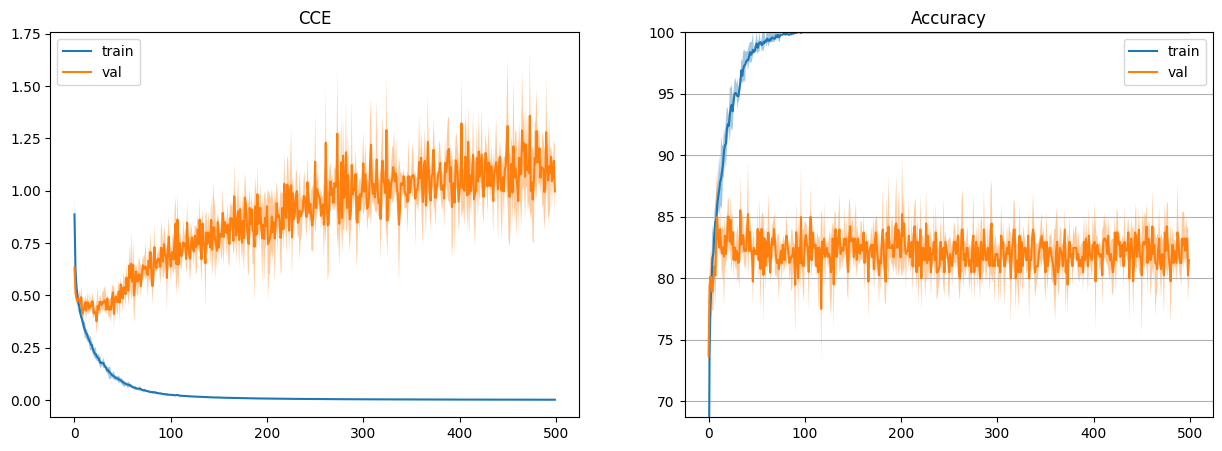

Обучение закончено за 31.012187242507935 секунд


In [ ]:
train(strideModel)

In [ ]:
check(strideModel)

### 2.

In [ ]:
model.hidden_size = HIDDEN_SIZE
maxPullingModel = model.maxPulling()
summary(maxPullingModel, input_size=(32, 32, 3))
maxPullingModel

In [ ]:
train(maxPullingModel)

In [ ]:
check(maxPullingModel)

### 3.

In [ ]:
model.hidden_size = HIDDEN_SIZE
averagePullingModel = model.averagePulling()
summary(averagePullingModel, input_size=(32, 32, 3))
averagePullingModel

In [ ]:
train(averagePullingModel)

In [ ]:
check(averagePullingModel)

In [ ]:
PATH = 'cifar_cnn.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

In [ ]:
!pip install onnx

In [ ]:
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

## Сохранение модели

In [ ]:
PATH = 'cifar_cnn.pt'
torch.save(model, PATH)

new_model_2 = torch.load(PATH, weights_only=False)
new_model_2.eval()

In [ ]:
!pip install onnx

In [ ]:
!pip install onnxscript
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})